In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import moviepy.editor as mp
from python_speech_features import mfcc, logfbank
from tqdm import tqdm
import scipy.signal

audio_files_folder = '../audio/'
pickles_folder = '../cleaned_pickles/'
output = '../clean_filtered/'
image_output = '../sound/'

In [2]:
def get_audio(file):
    audio = mp.AudioFileClip(audio_files_folder+file)
    fps = audio.fps
    sound_array = audio.to_soundarray(nbytes=4, buffersize=1000, fps=fps)
    return fps,sound_array[:,0]

In [3]:
def segment(sound_array, fps, start_time, stop_time):
    start_idx = int(start_time*fps)
    stop_idx = int(stop_time*fps)
    return sound_array[start_idx:stop_idx]
    

In [4]:
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n,d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return Y, freq

In [5]:
def custom_bank(arr, rate, window = 0.25,step_t = 0.10, max_idx = 250):


    step = int(step_t*rate) # Number of points in step_t seconds
    n_rows = int(len(arr)/(step))-2
    w = int(window*rate)
    freq_array = []
    
    for r in range(n_rows):
        start = r*step
        stop = start + w
        
        clip = arr[start:stop]
        y,f = calc_fft(clip, rate)
        freq_array.append(y[:max_idx])
        
        
    
    return np.array(freq_array), f[:max_idx]

In [6]:
filenames = os.listdir(audio_files_folder)
print(filenames)

['03_02_2019_08_28_44.3gp', '03_02_2019_09_07_22.3gp', '03_02_2019_08_54_53.3gp', '03_02_2019_08_41_24.3gp', '03_01_2019_02_45_21.3gp', '03_02_2019_08_10_00.3gp', '03_01_2019_02_36_27.3gp']


In [7]:
def save_as_csv(dictionary, filename):
    with open(filename, 'w') as f:
        
        headers = list(dictionary.keys())
        
        for header in headers:
            f.write(header+',')
        f.write('\n')
        
        for i in range(len(dictionary[header])):
            for h in headers:
                f.write(str(dictionary[h][i])+',')
            f.write('\n')
            

In [142]:
def find_anomalies(audio_file, thresh = 0.2, window = 1,graph=False):
    
    fps,sound_array = get_audio(audio_file) # get_audio() knows where to look
    cb, f = custom_bank(sound_array, fps)
    
    t_f = len(sound_array)/fps
    cb_sum = cb.sum(1)
    m = cb.mean(0)
    cb_above_thresh = np.multiply(cb_sum, cb_sum > thresh)
    
    cb_fps = len(cb_sum)/t_f
    t = t_f*np.arange(len(cb_sum))/len(cb_sum)
    peaks = scipy.signal.find_peaks(cb_above_thresh, distance = int(2*cb_fps/window))[0]
    
    if graph:
        plt.plot(t,cb_above_thresh)
        plt.scatter(t[peaks],cb_above_thresh[peaks],color='red')
        plt.xlim((0,100))
        plt.show()
    
    w = int(cb_fps*window/2)
    freq_of_peaks = []
    t_of_peaks = t[peaks]
    for p in peaks:
        seg = cb[p-w:p+w]
        y = seg.mean(0)
        y = y-m
        freq_of_peaks.append(y)
    
    if graph:
        for i in range(0,10,1):
            plt.plot(f,freq_of_peaks[i], linewidth=0.5)
    #     plt.plot(f,m)
        plt.xlim((50,400))
        plt.show()
    return freq_of_peaks, t_of_peaks, f

(243, 250)


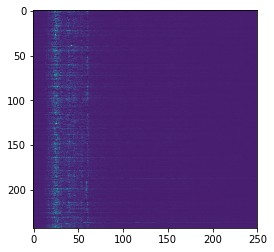

In [154]:
data = []
labels = []
for i in filenames:
    y,t,f = find_anomalies(i)
    for j,k in enumerate(y):
        data.append(k)
        labels.append((i,t[j]))
        

        
outfile = open('training_data.pkl','wb')
pickle.dump(data,outfile)
outfile.close()

outfile = open('labels.pkl','wb')
pickle.dump(labels,outfile)
outfile.close()

plt.imshow(data)
print(np.array(data).shape)

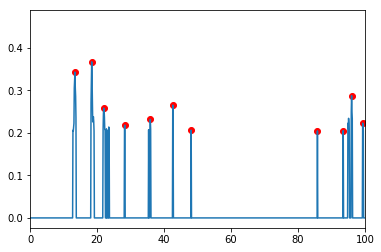

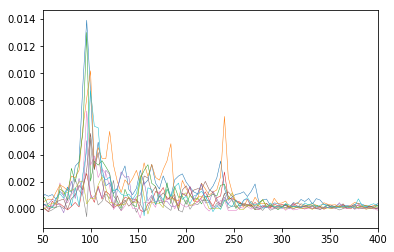

In [150]:
y,t,f = find_anomalies(filenames[0], graph=True)

In [147]:
fps,sound_array = get_audio(filenames[0])

13.404948562384597


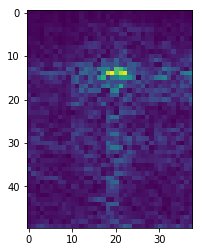

18.406795040886312


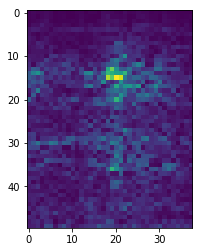

22.008124505407544


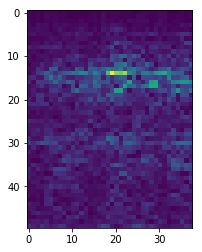

28.310451068319704


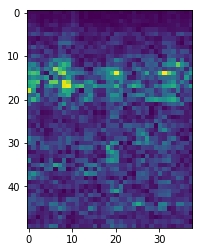

35.91325771564231


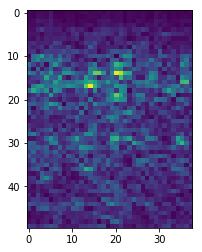

42.615731996834604


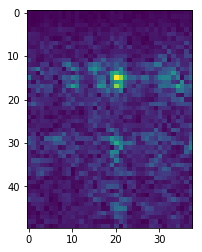

48.11776312318649


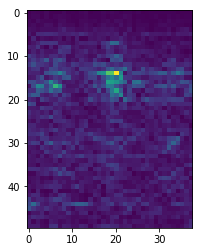

85.83168557108942


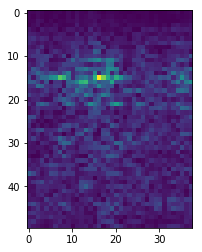

93.53452914798207


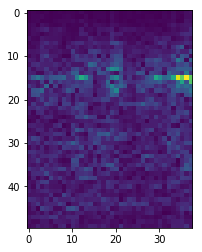

96.03545238723292


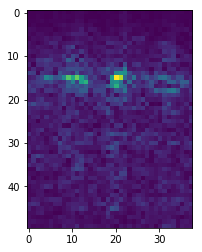

99.33667106304405


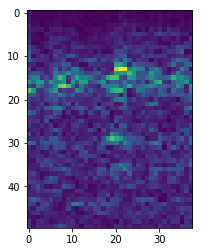

101.2373727248747


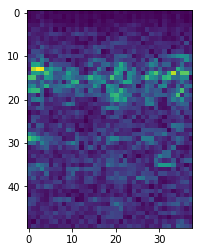

103.73829596412556


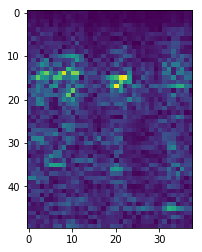

106.7394038512266


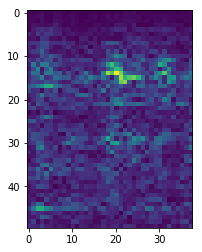

112.64158269585862


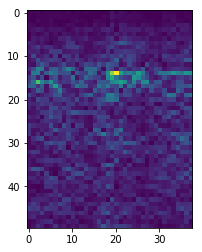

115.34257979424954


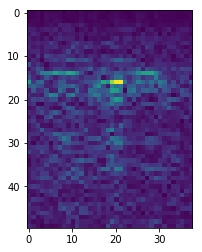

119.24402004748087


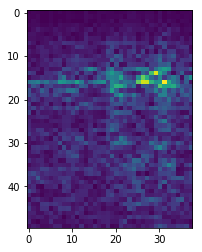

121.3447955684516


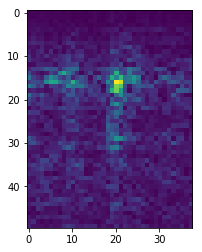

123.74568187813242


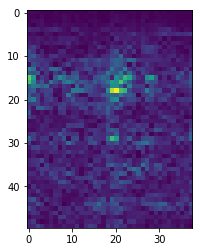

151.75602215774202


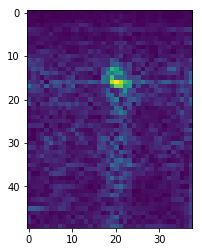

259.69586916380905


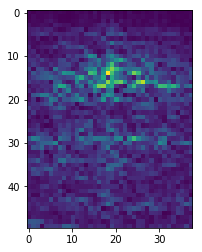

280.003365866526


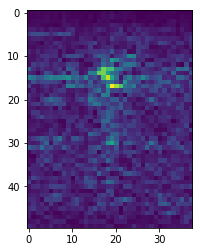

288.60654180954896


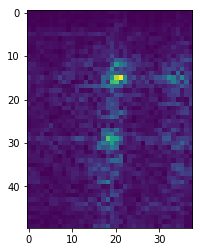

290.70731733051963


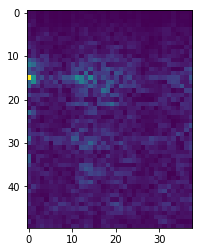

293.70842521762074


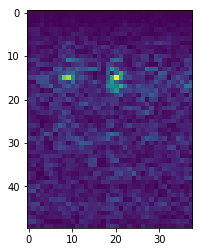

297.10968082300184


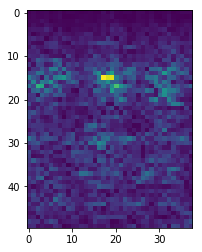

328.9214244262728


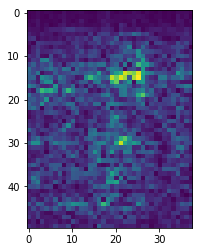

342.7265207069375


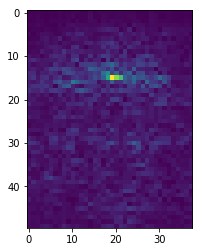

350.8295120021102


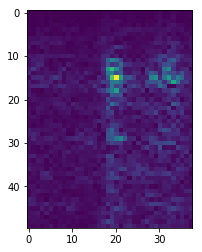

356.1314692693221


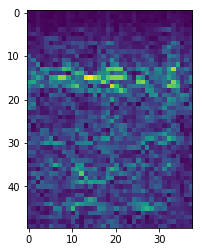

359.53272487470326


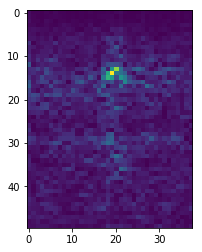

438.9620469533105


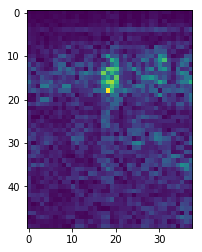

454.0676233183857


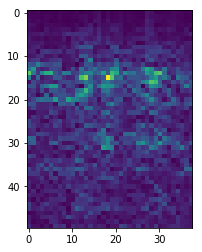

458.7693590081773


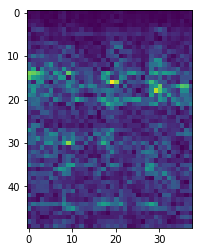

466.27212872592986


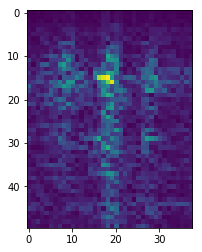

470.5737166974413


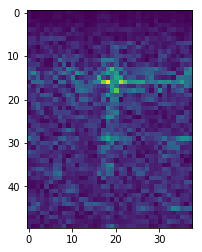

480.6774465840148


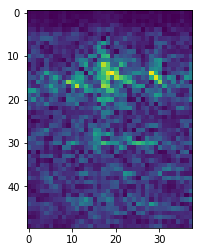

485.3791822738064


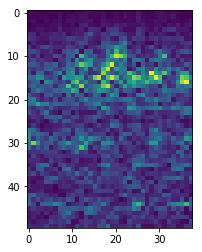

532.4965761012926


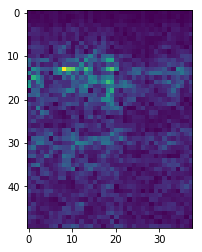

582.2149300975997


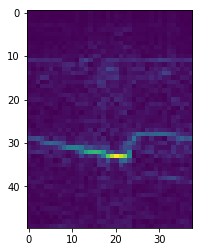

641.1366816143499


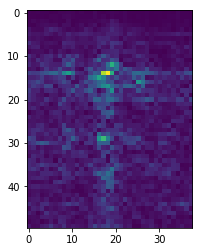

647.0388604589817


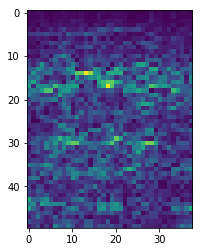

656.242257979425


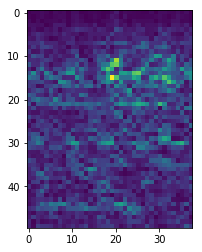

658.7431812186758


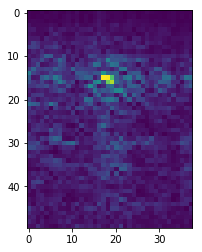

In [148]:
for i in t:
    print(i)
    seg = segment(sound_array,fps,i-2,i+2)
    cb,f = custom_bank(seg,fps)
    cb = cb[:,10:60]
    cb = 255*cb/cb.max()
    plt.imshow(cb.T)
    plt.show()

In [151]:
for i,j in enumerate(np.ones(5)):
    print(i)

0
1
2
3
4
